I have two dataset of rooten and fresh banana  
First google drive is mounted to access the data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


I got into this habit of inserting all the imports code in single code snippet

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torchvision.models import resnet18, ResNet18_Weights

lets get the gpu needed

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


Now i save the path to the data in two variables  
I will retrive data in the drive via these links

In [3]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_name = torch.cuda.get_device_name(0)
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1e9  # Convert bytes to GB
    print(f"Device: GPU ({gpu_name})")
    print(f"Total GPU Memory: {total_memory:.2f} GB")
    print(f"CUDA Capability: {torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}")
else:
    device = torch.device("cpu")
    print("Device: CPU")
    
# PyTorch version
print(f"PyTorch Version: {torch.__version__}")

# Selected device
print(f"Using device: {device}")


Device: GPU (NVIDIA GeForce GTX 1650)
Total GPU Memory: 4.29 GB
CUDA Capability: 7.5
PyTorch Version: 2.3.1+cu118
Using device: cuda


In [4]:
#Path to folders with data in drive
F_Banana = r"C:\Users\User\Desktop\DeepLearning\Major Project\F_Banana"
S_Banana = r"C:\Users\User\Desktop\DeepLearning\Major Project\S_Banana"
C_Belt   = r"C:\Users\User\Desktop\DeepLearning\Major Project\Black"

This code snippet retrives data from drive

<PIL.Image.Image image mode=RGB size=64x64 at 0x1CB7FC99050>


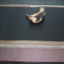

WIN_20241205_12_50_14_Pro.jpg


In [5]:
file_list =os.listdir(S_Banana) #file names in F-Banana are listed in file_list
file_name=file_list[200]
image_path=os.path.join(S_Banana, file_name)#full path to a particular file
image = Image.open(image_path).convert('RGB')  # Converting to RGB
image = image.resize((64, 64))#resizing the image
print(image)
display(image)
print(file_name)

So lets give a brief idea of whats been done till now an what things will be done in the future.

**Tillnow** we have able to retrive data from the drive link
we have a list of links of data which can be later used for training pupose

**Whats ahead?**
We need to design a dataloader which will load data onto the model
We need to make a model
Then use the model to predict the image

In [6]:
# Define labels
labels = {'fresh': 0, 'rotten': 1,'C_Belt':2}

# Load images and assign labels
data = []
for label, folder in [('fresh', F_Banana), ('rotten', S_Banana),('C_Belt', C_Belt)]:
    for file_name in os.listdir(folder):
        img_path = os.path.join(folder, file_name)
        if file_name.endswith(('.jpg', '.png', '.jpeg')):  # Filter image files
            data.append((img_path, labels[label]))

# Split into train and test datasets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define a transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to a standard size
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Custom Dataset class
class BananaDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
train_dataset = BananaDataset(train_data, transform=transform)
test_dataset = BananaDataset(test_data, transform=transform)

# Convert to DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Example: Checking one batch
for images, labels in train_loader:
    print(f"Batch of images: {images.shape}")  # Should be [batch_size, 3, 224, 224]
    print(f"Batch of labels: {labels}")
    break

Batch of images: torch.Size([64, 3, 224, 224])
Batch of labels: tensor([1, 0, 1, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 2, 0, 2, 1, 2, 2,
        2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 1, 1, 1, 2, 1,
        0, 1, 2, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 1, 1, 1])


In [7]:
print(train_dataset)

In [8]:
print(f"we have {len(train_data)} data for training and {len(test_data)} for testing")
#we have a huge dataset and we cant inset it directly into the

we have 1060 data for training and 266 for testing


its an matrics of numbers.

In [9]:
# Load the pre-trained ResNet18 model
#I have to import this paticular weights that is recommended cause the usual one threw loads and loads of warnings
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
# Freeze earlier layers
for param in model.parameters():
    param.requires_grad = False

# Modify the last two layers
# Replace the last fully connected layer (fc)
# Replace the second last layer (`layer4`)
model.layer4 = nn.Sequential(
    nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Match input channels (256)
    nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1))
)

# Replace the fc layer
model.fc = nn.Linear(256, 3)  # Adjusted for 256 output features from modified layer4

# Move model to the specified device
model = model.to(device)

# Print the model structure
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
print(next(model.parameters()).device)

cuda:0


In [11]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epoch=10
batch_size=64

In [12]:
# Initialize empty lists to store metrics
epoch_nums = []
test_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            print(batch)
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



# Test loop with proper appending
def test_loop(dataloader, model, loss_fn, epoch):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)

            all_preds.append(pred.argmax(1).cpu())
            all_labels.append(y.cpu())

            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    test_loss /= num_batches
    accuracy = correct / size
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    # Append values to the lists
    epoch_nums.append(epoch)  # Ensure this increments correctly
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Epoch {epoch}: Test Loss = {test_loss:.4f}, Accuracy = {accuracy:.4f}, "
          f"Precision = {precision:.4f}, Recall = {recall:.4f}, F1 Score = {f1:.4f}")


def final_plot():
    """Function to plot metrics in separate plots for better clarity."""
    # Plot Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_nums, accuracies, marker='o', linestyle='-', color='blue', label="Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Over Epochs")
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

    # Plot Precision

    # Plot Recall
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_nums, recalls, marker='s', linestyle='-.', color='red', label="Recall")
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("Recall Over Epochs")
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

    # Plot F1 Score
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_nums, f1_scores, marker='x', linestyle=':', color='purple', label="F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.title("F1 Score Over Epochs")
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

    # Plot Test Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epoch_nums, test_losses, marker='d', linestyle='-', color='orange', label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Test Loss")
    plt.title("Test Loss Over Epochs")
    plt.grid(True)
    plt.legend(loc="upper right")
    plt.show()


In [14]:
# Calculate total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 3373635


In [15]:
#now all we need to do is train and test the model for the number of times(epochs) we want
num_epochs=20
for epoch in range(1, num_epochs + 1):
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn, epoch)


0
loss: 1.099758  [    0/ 1060]
Epoch 1: Test Loss = 0.4164, Accuracy = 0.9436, Precision = 0.9534, Recall = 0.9436, F1 Score = 0.9439
0
loss: 0.338804  [    0/ 1060]
Epoch 2: Test Loss = 0.1902, Accuracy = 0.9887, Precision = 0.9892, Recall = 0.9887, F1 Score = 0.9887
0
loss: 0.191664  [    0/ 1060]
Epoch 3: Test Loss = 0.0948, Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
0
loss: 0.074560  [    0/ 1060]
Epoch 4: Test Loss = 0.0509, Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
0
loss: 0.050283  [    0/ 1060]
Epoch 5: Test Loss = 0.0403, Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
0
loss: 0.052537  [    0/ 1060]
Epoch 6: Test Loss = 0.0229, Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
0
loss: 0.019869  [    0/ 1060]
Epoch 7: Test Loss = 0.0177, Accuracy = 1.0000, Precision = 1.0000, Recall = 1.0000, F1 Score = 1.0000
0
loss: 0.013585  [    0/ 1060]
Epoch 8: Test Loss = 0.

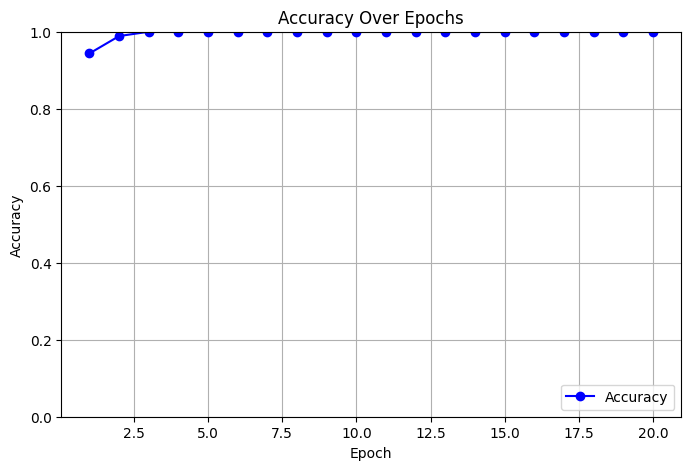

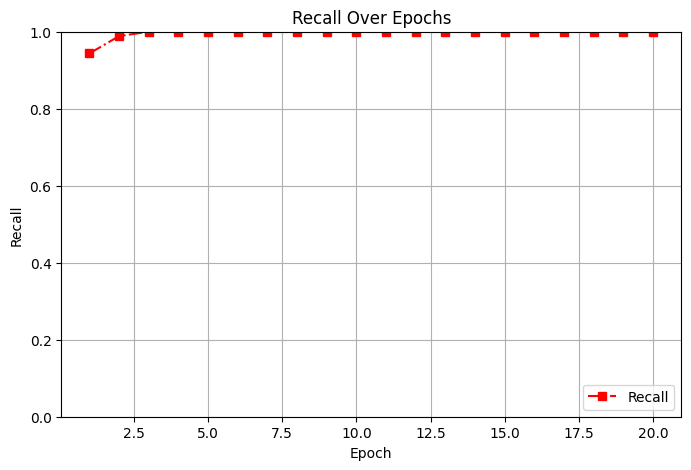

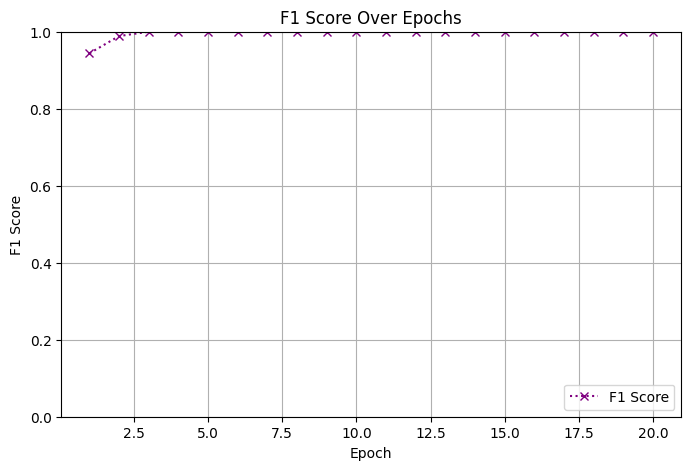

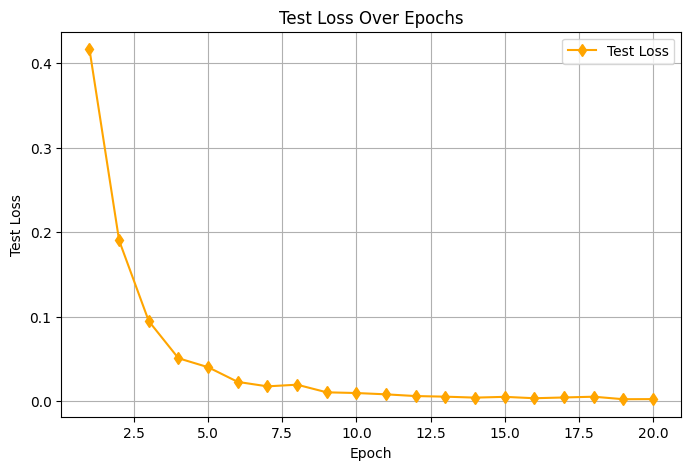

In [16]:
final_plot()

In [17]:
save_path = r"C:\Users\User\Desktop\DeepLearning\Major Project\resnet_model_parameters_6.0.pth"
torch.save(model.state_dict(), save_path)
print(f"Model parameters saved to {save_path}")

Model parameters saved to C:\Users\User\Desktop\DeepLearning\Major Project\resnet_model_parameters_6.0.pth


In [18]:
# directly loading the model parameters if you have already trained the model
model.load_state_dict(torch.load(r"C:\Users\User\Desktop\DeepLearning\Major Project\resnet_model_parameters_6.0.pth"))
model.eval()  # Set the model to evaluation mode (important for inference)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# Iterate through the dataloader to fetch a batch of images and labels
for i, (images, labels) in enumerate(test_loader):
    # Move images and labels to the CPU (Pillow works with CPU tensors)
    images, labels = images.cpu(), labels.cpu()

    # Transform tensor images back to PIL format for display
    to_pil = transforms.ToPILImage()

    for j in range(min(1, len(images))):  # Limit to 5 images
        # Convert tensor to PIL image
        pil_image = to_pil(images[j])

        # Display image with Pillow
        print(f"Predicted value of the image is: {model(images.to(device)).argmax(1)[j].item()}")
        print(f"Actual label of the image is: {labels[j].item()}")

        # Display the image using Pillow
        pil_image.show()

    # Break after processing the first batch (only for demonstration)
    break


Predicted value of the image is: 2
Actual label of the image is: 2
